In [1]:
import torch
import torch.utils.data
import torch.cuda
import torch.optim
import torch.nn
import torch.nn.functional as F
import cv2
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

def imshow(imgs, label=""):
    imgs = vutils.make_grid(imgs, normalize=True)
    fig, ax = plt.subplots(1, squeeze=False, frameon=False, dpi=300)
    ax[0][0].imshow(np.transpose(imgs.cpu().detach().numpy(), (1, 2, 0)), interpolation="nearest")  # type: ignore
    ax[0][0].axis("off")  # type: ignore
    ax[0][0].set_title(label)  # type: ignore
    fig.show()  # type: ignore

In [2]:
datadir = Path('../../data')
patchesdir = Path('../Patches')
maindir = Path('..')

# imagenet
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

img_size = 400

mean, std = np.array(mean, dtype=float), np.array(std, dtype=float)

to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

tr = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0), ratio=(1., 1.)),
    to_tensor
])

inv_norm = transforms.Compose([
    transforms.Normalize(np.zeros(3), 1/std),
    transforms.Normalize(-mean, np.ones(3))
])

to_pil = transforms.Compose([
    inv_norm,
    transforms.Lambda(lambda img: torch.clamp(img, 0, 1)),
    transforms.ToPILImage()
])

sampler = torch.utils.data.RandomSampler

trainset = datasets.ImageNet(root=str(datadir), split='train', transform=tr)
testset  = datasets.ImageNet(root=str(datadir), split='val',   transform=tr)

def subset(imageset, size):
    res, _ = torch.utils.data.random_split(imageset, [size, len(imageset) - size])
    return res

def dataloader(imageset, batch_size):
    return torch.utils.data.DataLoader(imageset, batch_size=batch_size, shuffle=True)

In [3]:
from torchvision import models

ensemble = {
    'ResNet101'    : models.resnet101(pretrained=True),
    'VGG16'        : models.vgg16(pretrained=True),
    'VGG19_with_bn': models.vgg19_bn(pretrained=True),
    'GoogLeNet'    : models.googlenet(pretrained=True),
    'Inception_v3' : models.inception_v3(pretrained=True)
}

for model in ensemble.values():
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

ensemble = list(ensemble.items())

In [13]:
from patch_maker import PatchMaker

device = torch.device("cuda")

pm_test = PatchMaker(mean, std, device=device)

patch = Image.open(patchesdir/"owlpatch"/"owlpatch_ep_59.png")
pm_test.set_patch(to_tensor(patch))
pm_test.set_transforms(rotate_angle=(-180, 180), shear=(0, 0.1), size_by_im=(0.1, 0.3))
modelname, model = ensemble[0]
model = model.to(device)
modelname

'ResNet101'

In [5]:
def get_gx(tensor):
    B, C, W, H = tensor.shape
    sobelx = torch.tensor([[1,0,-1], [2,0,-2], [1,0,-1]], device=device).float()
    sobely = sobelx.T

    G_x = F.conv2d(tensor.view(-1,1, W, H), sobelx.view((1,1,3,3)),padding=1).view(B, C, W, H)
    G_y = F.conv2d(tensor.view(-1,1, W, H), sobely.view((1,1,3,3)),padding=1).view(B, C, W, H)

    G = torch.sqrt(torch.pow(G_x, 2)+torch.pow(G_y, 2)).float()

    gx = (G-G.min())/(G.max()-G.min())
    return gx

def get_gradient(tensor, block_size=15, overlap=5, threshold=0):
    
    stride = block_size - overlap
    padding = []
    for v in tensor.shape[-2:]:
        left = v % stride
        if left <= overlap:
            need = overlap
        else:
            need = block_size
        pad = need - left
        padding.append(int(pad / 2))
        padding.append(pad - padding[-1])

    tensor = F.pad(tensor, tuple(padding))

    B, C, W, H = tensor.shape

    patches = tensor.unfold(2, block_size, stride).unfold(3, block_size, stride)
    mask = ((patches.sum([1,-2,-1]) / torch.prod(torch.tensor(patches.shape)[[1,-2,-1]])) >= threshold).float().unsqueeze(1).unsqueeze(-1).unsqueeze(-1)

    def fold(x):
        x = x * mask
        x = x.contiguous().view(B, C, -1, block_size * block_size).permute(0, 1, 3, 2)
        x = x.contiguous().view(B, C*block_size*block_size, -1)
        return F.fold(x, output_size=(H,W), kernel_size=block_size, stride=stride)

    ox = torch.ones_like(patches)
    r =  fold(patches) / fold(ox)
    r = F.pad(r, tuple(-i for i in padding))
    r[r != r] = 0
    return r
    
def apply_gradient(img, grad, smooth_factor=2.3):
    t = 1 - grad * smooth_factor
    clipped = torch.clip(t, 0, 1)
    return torch.mul(img, clipped)

def lgs(tensor, threshold=0.2, smooth_factor=2.3, block_size=15, overlap=5):
    return apply_gradient(tensor, get_gradient(get_gx(tensor), block_size=block_size, overlap=overlap, threshold=threshold), smooth_factor=smooth_factor)
    

In [6]:
def test(model, target, threshold=0.2, smooth_factor=2.3, batch_size=10, test_size=50000):
    scores = {
        "plain": 0,
        "with_patch": 0,
        "patch_succeed": 0,
        "with_patch_LGS": 0,
        "plain_LGS": 0,
        "patch_LGS_succeed": 0
    }
    
    dl = dataloader(subset(testset, test_size), batch_size)
    epbar = tqdm(dl, leave=False)
    for data, labels in epbar:
        try:
            data = data.to(device)
            labels = labels.to(device)
            
            _, preds = model(data).max(1)
            scores["plain"] += (labels == preds).float().sum().item() / test_size
            
            x = pm_test.random_patch_place(data)
            _, preds = model(x).max(1)
            scores["with_patch"] += (labels == preds).float().sum().item() / test_size
            scores["patch_succeed"] += (preds == (torch.ones_like(labels) * target)).float().sum().item() / test_size
            
            data = lgs(data, threshold=threshold, smooth_factor=smooth_factor)
            _, preds = model(data).max(1)
            scores["plain_LGS"] += (labels == preds).float().sum().item() / test_size
            
            x = lgs(x, threshold=threshold, smooth_factor=smooth_factor)
            _, preds = model(x).max(1)
            scores["with_patch_LGS"] += (labels == preds).float().sum().item() / test_size
            scores["patch_LGS_succeed"] += (preds == (torch.ones_like(labels) * target)).float().sum().item() / test_size
            
        except KeyboardInterrupt:
            break
    epbar.close()
    return scores
    

In [22]:
thresholds = np.linspace(0, 0.5, num=20)
threshold_scores = [
    test(model, 24, test_size=1000, batch_size=10, threshold=i, smooth_factor=2.3) for i in tqdm(thresholds)
]

In [23]:
tscores_d = {
    key: [i[key] for i in threshold_scores] for key in threshold_scores[0].keys()
}
tscores_d_acc = {
    key: tscores_d[key] for key in ("plain", "with_patch", "with_patch_LGS", "plain_LGS")
}
tscores_d_patch = {
    key: tscores_d[key] for key in ("patch_succeed", "patch_LGS_succeed")
}

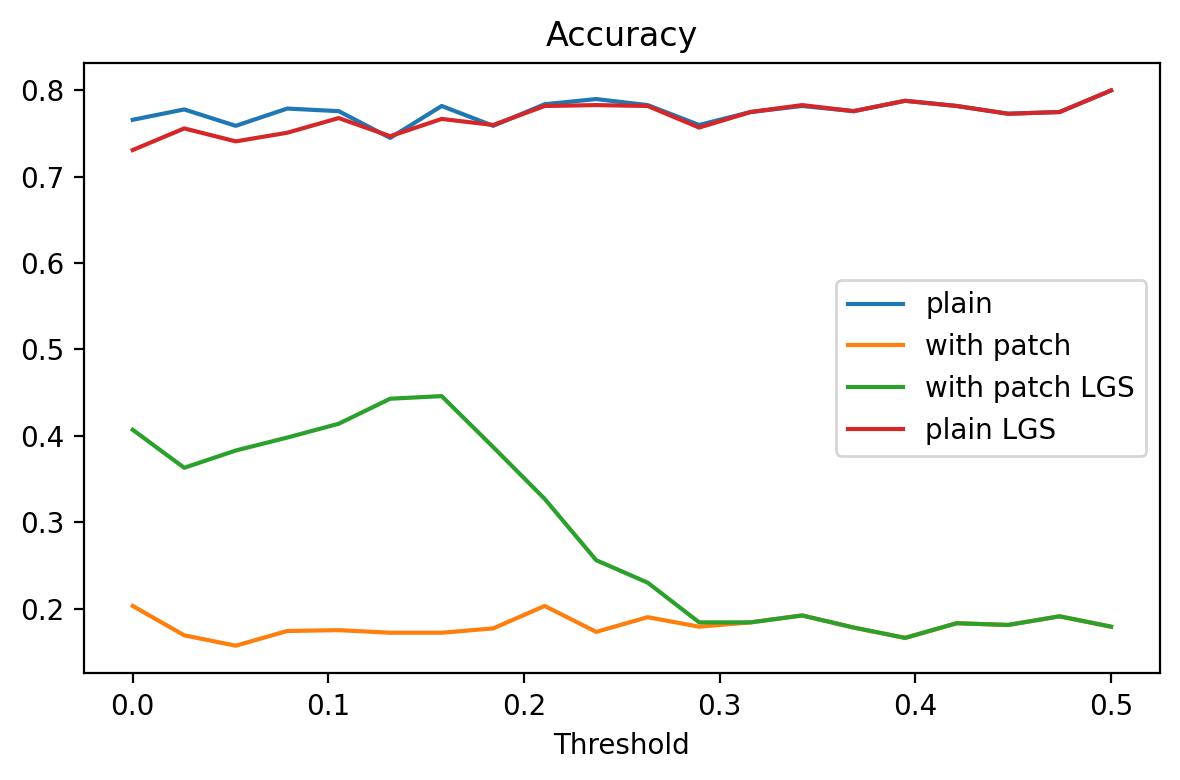

In [30]:
fig, ax = plt.subplots(1,1, squeeze=False, dpi=200)
for phase, ls in tscores_d_acc.items():
    ax[0][0].plot(thresholds, ls, label=phase.replace("_", " "))
ax[0][0].legend()
ax[0][0].set_title('Accuracy')
ax[0][0].set_xlabel('Threshold')
fig.tight_layout()

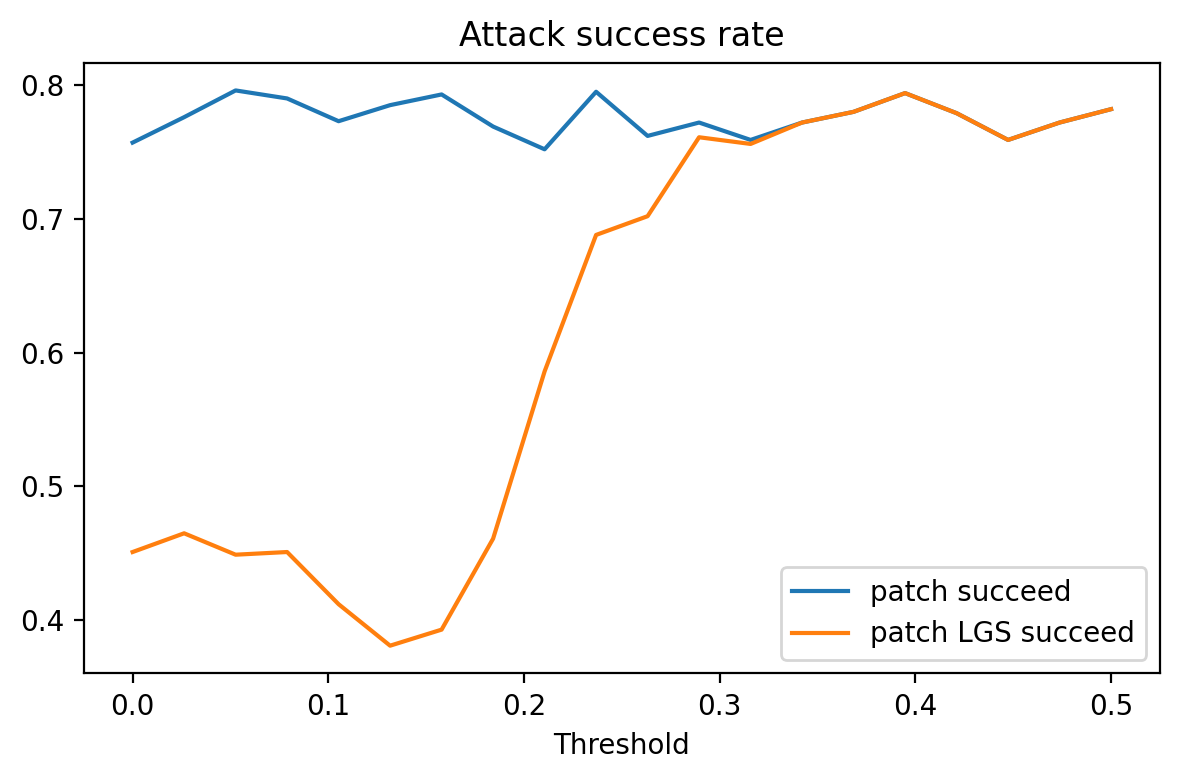

In [31]:
fig, ax = plt.subplots(1,1, squeeze=False, dpi=200)
for phase, ls in tscores_d_patch.items():
    ax[0][0].plot(thresholds, ls, label=phase.replace("_", " "))
ax[0][0].legend()
ax[0][0].set_title('Attack success rate')
ax[0][0].set_xlabel('Threshold')
fig.tight_layout()

In [ ]:
factors = np.linspace(0.5, 5, num=20)
factor_scores = [
    test(model, 24, test_size=1000, batch_size=10, threshold=0.13, smooth_factor=i) for i in tqdm(factors)
]
fscores_d = {
    key: [i[key] for i in factor_scores] for key in factor_scores[0].keys()
}
fscores_d_acc = {
    key: fscores_d[key] for key in ("plain", "with_patch", "with_patch_LGS", "plain_LGS")
}
fscores_d_patch = {
    key: fscores_d[key] for key in ("patch_succeed", "patch_LGS_succeed")
}

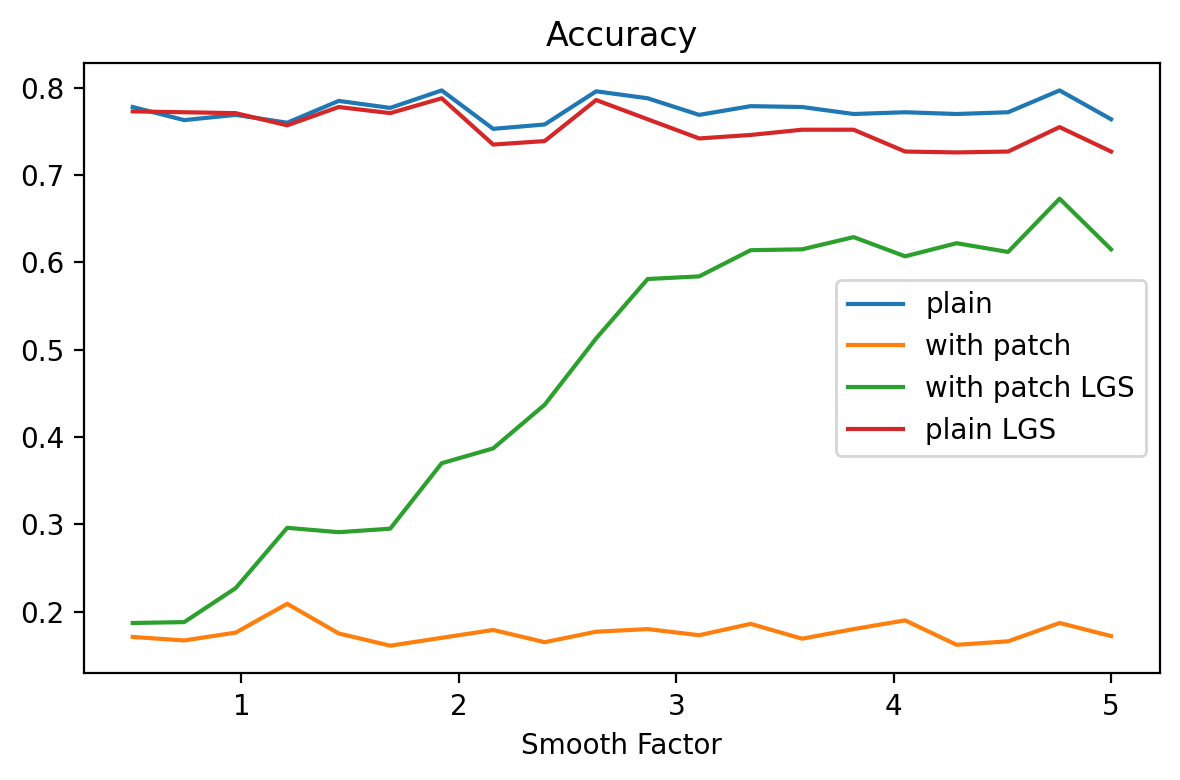

In [33]:
fig, ax = plt.subplots(1,1, squeeze=False, dpi=200)
for phase, ls in fscores_d_acc.items():
    ax[0][0].plot(factors, ls, label=phase.replace("_", " "))
ax[0][0].legend()
ax[0][0].set_title('Accuracy')
ax[0][0].set_xlabel('Smooth Factor')
fig.tight_layout()

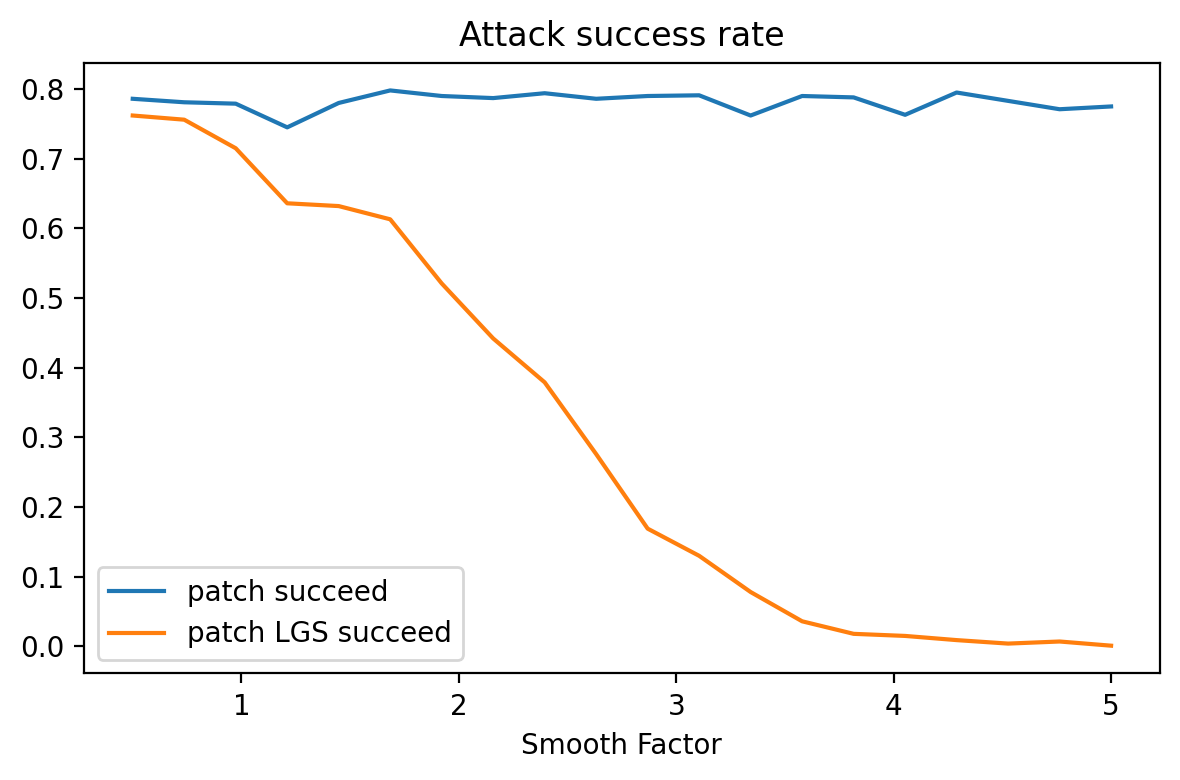

In [34]:
fig, ax = plt.subplots(1,1, squeeze=False, dpi=200)
for phase, ls in fscores_d_patch.items():
    ax[0][0].plot(factors, ls, label=phase.replace("_", " "))
ax[0][0].legend()
ax[0][0].set_title('Attack success rate')
ax[0][0].set_xlabel('Smooth Factor')
fig.tight_layout()

In [14]:
scores = test(model, 24, test_size=1000, batch_size=10, threshold=0.13, smooth_factor=3.7)
scores

{'plain': 0.7670000000000006,
 'with_patch': 0.18800000000000014,
 'patch_succeed': 0.7730000000000006,
 'with_patch_LGS': 0.6190000000000004,
 'plain_LGS': 0.7350000000000005,
 'patch_LGS_succeed': 0.036000000000000025}